In [26]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
file_path = "Project1 Data.csv"  # Update path if needed
df = pd.read_csv(file_path)

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Select target variable (LL100) and exogenous variables
exog_vars = ['SP500', 'FINA', 'INDU']  # Key market indicators
ts = df['LL100'].interpolate()
exog_data = df[exog_vars].interpolate().fillna(method='bfill')

# Normalize data
scaler_y = MinMaxScaler()
ts_scaled = scaler_y.fit_transform(ts.values.reshape(-1, 1)).flatten()

scaler_exog = MinMaxScaler()
exog_scaled = scaler_exog.fit_transform(exog_data)

# Prepare dataset for LSTM
sequence_length = 20  # Use past 20 days to predict the next day
train_size = int(len(ts) * 0.8)

def create_sequences(y_data, exog_data, seq_length):
    X, y = [], []
    for i in range(len(y_data) - seq_length - 1):  # Adjusted for 1-step forecast
        X.append(np.hstack([y_data[i:i+seq_length].reshape(-1, 1), exog_data[i:i+seq_length]]))
        y.append(y_data[i+seq_length])  # Predict next 1 day
    return torch.tensor(np.array(X), dtype=torch.float32), torch.tensor(np.array(y), dtype=torch.float32)

# Split into train & test
X, y = create_sequences(ts_scaled, exog_scaled, sequence_length)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Create DataLoader
batch_size = 32
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=False)

# Define LSTM Model
class LSTMPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)  # Predict next 1 day

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

# Initialize Model
input_size = X_train.shape[2]  # Number of input features
hidden_size = 64
num_layers = 3
model = LSTMPredictor(input_size, hidden_size, num_layers).to(device)

# Loss & Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Train LSTM Model
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss/len(train_loader):.6f}")

# Evaluate Model
model.eval()
predictions, actuals = [], []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        pred = model(batch_x).squeeze().cpu().numpy()
        predictions.extend(pred)
        actuals.extend(batch_y.numpy())


C:\Users\zcz20\AppData\Local\Temp\ipykernel_29984\91885800.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  exog_data = df[exog_vars].interpolate().fillna(method='bfill')


Epoch [1/200], Loss: 0.045330
Epoch [2/200], Loss: 0.003462
Epoch [3/200], Loss: 0.001814
Epoch [4/200], Loss: 0.000604
Epoch [5/200], Loss: 0.000318
Epoch [6/200], Loss: 0.000386
Epoch [7/200], Loss: 0.000340
Epoch [8/200], Loss: 0.000395
Epoch [9/200], Loss: 0.000301
Epoch [10/200], Loss: 0.000189
Epoch [11/200], Loss: 0.000209
Epoch [12/200], Loss: 0.000196
Epoch [13/200], Loss: 0.000260
Epoch [14/200], Loss: 0.000198
Epoch [15/200], Loss: 0.000164
Epoch [16/200], Loss: 0.000167
Epoch [17/200], Loss: 0.000182
Epoch [18/200], Loss: 0.000216
Epoch [19/200], Loss: 0.000276
Epoch [20/200], Loss: 0.000258
Epoch [21/200], Loss: 0.000195
Epoch [22/200], Loss: 0.000387
Epoch [23/200], Loss: 0.000155
Epoch [24/200], Loss: 0.000199
Epoch [25/200], Loss: 0.000226
Epoch [26/200], Loss: 0.000131
Epoch [27/200], Loss: 0.000139
Epoch [28/200], Loss: 0.000152
Epoch [29/200], Loss: 0.000134
Epoch [30/200], Loss: 0.000114
Epoch [31/200], Loss: 0.000108
Epoch [32/200], Loss: 0.000136
Epoch [33/200], L

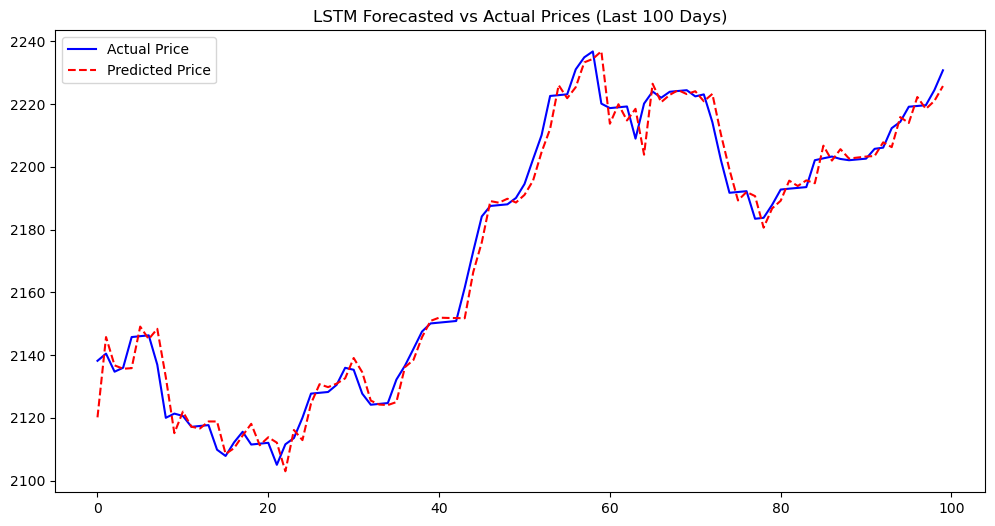

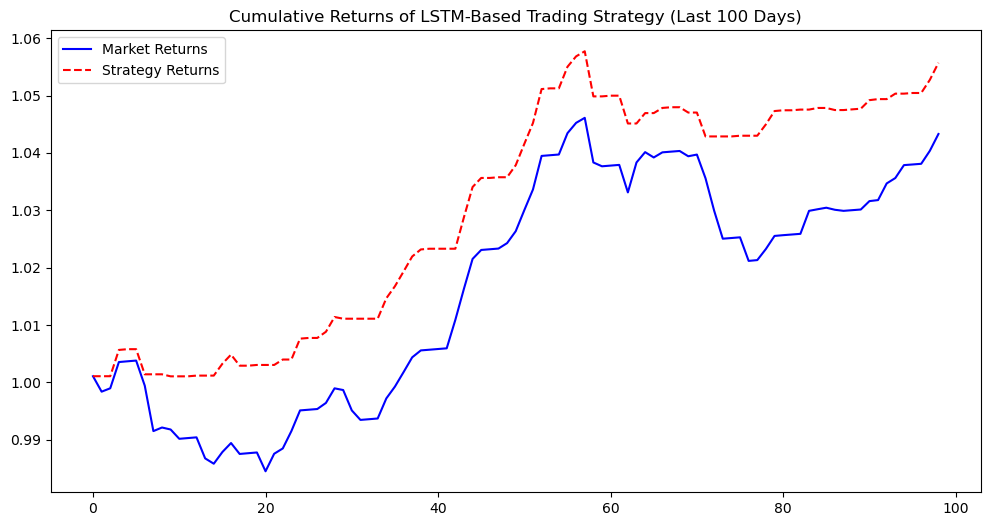

In [27]:

# Inverse transform predictions & actuals
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

# Backtest: Predicting last 100 days
test_period = 100
predictions_backtest, actuals_backtest = predictions[-test_period:], actuals[-test_period:]

# Compute MSE for backtest
mse_backtest = mean_squared_error(actuals_backtest, predictions_backtest)

# Compute daily returns
returns_actual = np.diff(actuals_backtest) / actuals_backtest[:-1]
returns_predicted = np.diff(predictions_backtest) / predictions_backtest[:-1]

# Generate trading signals
signals = np.where(returns_predicted > 0, 1, 0)  # Buy if predicted return is positive
strategy_returns = signals[:len(returns_actual)] * returns_actual

# Compute cumulative returns
cumulative_strategy_returns = np.cumprod(1 + strategy_returns)
cumulative_market_returns = np.cumprod(1 + returns_actual)

# Plot forecasted price vs actual price
plt.figure(figsize=(12, 6))
plt.plot(actuals_backtest, label='Actual Price', color='blue')
plt.plot(predictions_backtest, label='Predicted Price', linestyle='dashed', color='red')
plt.legend()
plt.title("LSTM Forecasted vs Actual Prices (Last 100 Days)")
plt.show()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_market_returns, label='Market Returns', color='blue')
plt.plot(cumulative_strategy_returns, label='Strategy Returns', linestyle='dashed', color='red')
plt.legend()
plt.title("Cumulative Returns of LSTM-Based Trading Strategy (Last 100 Days)")
plt.show()

# Display results
mse_results = pd.DataFrame({'Forecast Horizon': ['1-Day Ahead'], 'MSE': [mse_backtest]})


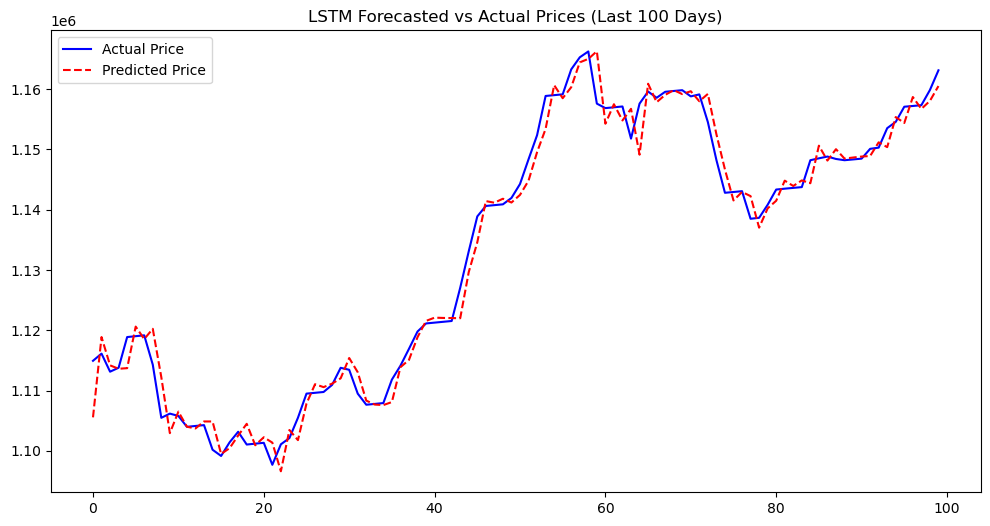

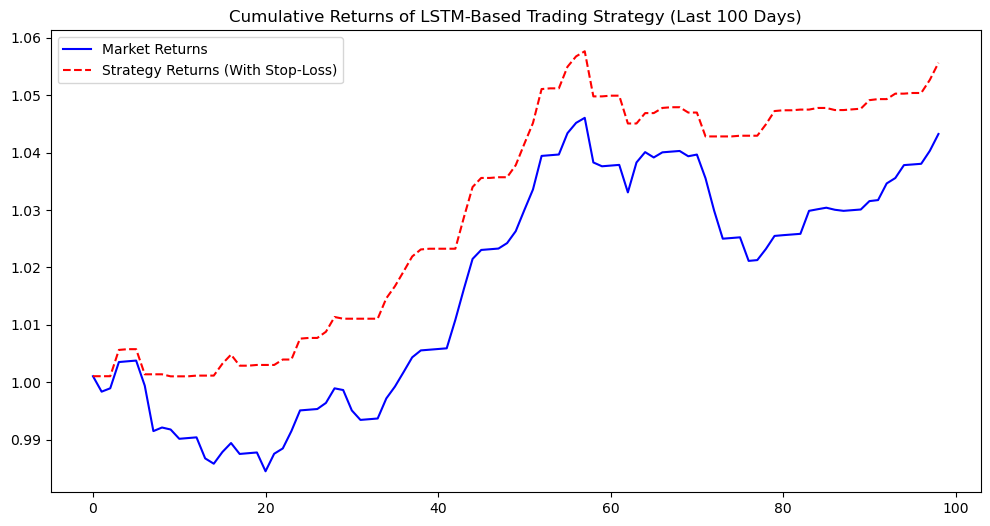

In [28]:

# Inverse transform predictions & actuals
predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

# Backtest: Predicting last 100 days
test_period = 100
predictions_backtest, actuals_backtest = predictions[-test_period:], actuals[-test_period:]

# Compute MSE for backtest
mse_backtest = mean_squared_error(actuals_backtest, predictions_backtest)

# Compute daily returns
returns_actual = np.diff(actuals_backtest) / actuals_backtest[:-1]
returns_predicted = np.diff(predictions_backtest) / predictions_backtest[:-1]

# Generate trading signals
signals = np.where(returns_predicted > 0, 1, 0)  # Buy if predicted return is positive
strategy_returns = signals[:len(returns_actual)] * returns_actual  # Apply signals to actual returns

# Implement Stop-Loss Condition
stop_loss_threshold = -0.02  # Stop loss at -2%
strategy_returns = np.where(strategy_returns < stop_loss_threshold, stop_loss_threshold, strategy_returns)

# Compute cumulative returns
cumulative_strategy_returns = np.cumprod(1 + strategy_returns)
cumulative_market_returns = np.cumprod(1 + returns_actual)

# Plot forecasted price vs actual price
plt.figure(figsize=(12, 6))
plt.plot(actuals_backtest, label='Actual Price', color='blue')
plt.plot(predictions_backtest, label='Predicted Price', linestyle='dashed', color='red')
plt.legend()
plt.title("LSTM Forecasted vs Actual Prices (Last 100 Days)")
plt.show()

# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(cumulative_market_returns, label='Market Returns', color='blue')
plt.plot(cumulative_strategy_returns, label='Strategy Returns (With Stop-Loss)', linestyle='dashed', color='red')
plt.legend()
plt.title("Cumulative Returns of LSTM-Based Trading Strategy (Last 100 Days)")
plt.show()

# Display results
mse_results = pd.DataFrame({'Forecast Horizon': ['1-Day Ahead'], 'MSE': [mse_backtest]})


In [29]:
mse_results

,Forecast Horizon,MSE
0,1-Day Ahead,8000059.0
